In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    colab_loc='/content/drive/My Drive/Colab Notebooks/RT-predict/'
    loc=colab_loc
except:
    loc=''
    from  infrastructure import profiler_parse
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.auto import tqdm
columns=['benchmark','input','pid','function','call occurrence','runtime (sec)','cache misses','cache references','retired instructions','branch misses','page faults']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#data_mat,columns=profiler_parse.read_datafile('data/10_runs_5_inputs_5_bmarks_raw.csv')

In [2]:
with open(loc+'data/cleaned_data_no_header.pkl','rb') as f: 
    data_mat = pickle.load(f)

In [3]:
data=pd.DataFrame(data_mat,columns=columns)
for column in ['pid','call occurrence','cache misses','cache references','retired instructions','branch misses','page faults']:
    data[column] = data[column].astype("int64")
for column in ['benchmark','input','function']:
    data[column] = data[column].astype("string")
data['runtime (sec)'] = data['runtime (sec)'].astype('float64') 
print(data.dtypes)
data.head()

benchmark                string
input                    string
pid                       int64
function                 string
call occurrence           int64
runtime (sec)           float64
cache misses              int64
cache references          int64
retired instructions      int64
branch misses             int64
page faults               int64
dtype: object


,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,sim_fast,39228,main,0,0.0001,5545,14442,164402,2475,83
1,disparity,sim_fast,39228,__wrap_malloc,0,0.0001,2368,7335,27607,734,13
2,disparity,sim_fast,39228,readImage,0,0.0001,117,576,570754,60,1
3,disparity,sim_fast,39228,readImage,0,0.0001,5,190,604818,37,1
4,disparity,sim_fast,39228,readImage,0,0.0001,225,1536,234594,113,1


In [69]:
# compute application and function performance profiles
app_profiles=data.groupby(['benchmark','input','pid'])[['runtime (sec)','cache misses' ,'cache references' ,'retired instructions','branch misses','page faults']].sum().reset_index()
functions=data.groupby(['benchmark','input','pid','function','call occurrence']).sum().reset_index()
columns_to_norm=['runtime (sec)','cache misses' ,'cache references' ,'retired instructions','branch misses','page faults']
#normalize functions profiles
normed_functions=functions.copy()
for column in tqdm(columns_to_norm):
    func_vals=normed_functions[column]
    app_vals=app_profiles[column]
    tmp=None
    for pid in tqdm(app_profiles['pid']):
        normed_functions.loc[functions['pid'] == pid,column]= func_vals[functions['pid'] == pid].to_numpy() / app_vals[app_profiles['pid']==pid].to_numpy()
    

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [70]:
app_profiles.head()

,benchmark,input,pid,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,cif,40324,2.0084,15641322,48003642,1669488481,182442,1185
1,disparity,cif,40326,2.0024,15030563,45206489,1669523576,178825,1198
2,disparity,cif,40328,2.0021,14394587,45751927,1669483582,177562,1181
3,disparity,cif,40330,2.0035,18336248,51241854,1669524305,181929,1203
4,disparity,cif,40332,2.0037,14584565,45526310,1669522548,178624,1201


In [ ]:
functions.head()

,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,cif,40324,0x7f8630b2a560,0,0.9929,903,1779,2708,107,2
1,disparity,cif,40324,0x7f8630b2cbb1,0,0.0019,5051,11826,127975,2002,64
2,disparity,cif,40324,__wrap_malloc,0,0.0001,236,1543,165633,95,11
3,disparity,cif,40324,__wrap_malloc,1,0.0001,365,1784,156339,48,0
4,disparity,cif,40324,__wrap_malloc,2,0.0002,61,257,121,19,0


In [ ]:
normed_functions.head()

,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,cif,40324,0x7f8630b2a560,0,0.494374,0.000058,0.000037,1.622054e-06,0.000586,0.001688
1,disparity,cif,40324,0x7f8630b2cbb1,0,0.000946,0.000323,0.000246,7.665522e-05,0.010973,0.054008
2,disparity,cif,40324,__wrap_malloc,0,0.000050,0.000015,0.000032,9.921183e-05,0.000521,0.009283
3,disparity,cif,40324,__wrap_malloc,1,0.000050,0.000023,0.000037,9.364485e-05,0.000263,0.000000
4,disparity,cif,40324,__wrap_malloc,2,0.000100,0.000004,0.000005,7.247729e-08,0.000104,0.000000


In [7]:
def feature_grid_clusters(data,labels,title):
    u_labels = np.unique(labels)
    num = 0
    plt.figure(figsize=(10, 10))
    plt.title(title)
    for i in range(1, data.shape[1]):
        for j in range(1, data.shape[1]):
            num += 1
            plt.subplot(data.shape[1], data.shape[1], num)
            for k in u_labels:
                plt.scatter(data[labels == k, i],
                            data[labels == k, j], label=k)
    plt.show()


In [6]:
def plot_clusters(data,labels,title):
    plt.title(title)
    pca = PCA(2)
    read_data=pca.fit_transform(data)
    u_labels=np.unique(labels)
    for k in u_labels:
        filtered=read_data[labels==k]
        plt.scatter(filtered[0],filtered[1],label=k)

In [5]:
def evaluate_clusterings(X,clusterings=['KMeans','GMM','Agglomerative (Ward)','OPTICS'],clusters_list=range(2,25+1)):
    best_clusterings = []
    best_labels=[]
    plt.figure(figsize=(10, 10))
    cluster_num=len(clusterings)
    if cluster_num % 2 != 0:
        cluster_num+=1
    if 'KMeans' in clusterings:
        cluster_num+=1
    for i in tqdm(range(len(clusterings))):
        clustering=clusterings[i]
        print(f'Evaluating {clustering} clustering')
        scores = []
        kmeans_costs=[]
        labels=[]
        tmp_clusterings = []
        for clusters in tqdm(clusters_list):
            if clustering == 'KMeans':
                tmp_clustering = KMeans(random_state=0,n_clusters=clusters)
            elif clustering == 'GMM':
                tmp_clustering = GaussianMixture(random_state=0,n_components=clusters)
            elif clustering == 'DBSCAN':
                clusters=clusters/X.shape[1]
                tmp_clustering=DBSCAN(n_jobs=-1)
            elif clustering == 'OPTICS':
                tmp_clustering=OPTICS(n_jobs=-1,)
            elif 'Agglomerative' in clustering:
                tmp_clustering=AgglomerativeClustering(n_clusters=clusters)
            elif clustering == 'Spectral':
                tmp_clustering=SpectralClustering(random_state=0,n_clusters=clusters)
            labels.append(tmp_clustering.fit_predict(X))
            tmp_clusterings.append(tmp_clustering)
            score=silhouette_score(X, labels[-1])
            scores.append(score)
            if clustering == 'KMeans':
              kmeans_costs.append(tmp_clustering.inertia_)
        best = np.argmax(scores)
        #print(f'{clustering} scores: {scores} best id: {best}')
        print(f'best: clusters:{np.unique(labels[best]).shape[0]} score:{scores[best]}')
        best_clusterings.append(tmp_clusterings[best])
        best_labels.append(labels[best])
        if clustering != 'DBSCAN' and clustering !='OPTICS':
            plt.subplot(cluster_num//2+1,cluster_num//2+1,i+1)
            plt.title(clustering+" silouhette score")
            plt.plot(clusters_list, scores)
        if clustering == 'KMeans':
            i+=1
            plt.subplot(cluster_num//2+1,cluster_num//2+1,i+1)
            plt.title(clustering+' cost')
            plt.plot(clusters_list, kmeans_costs)
    plt.show()
    return best_clusterings,best_labels,clusterings

In [19]:
X=functions[columns_to_norm].to_numpy()

  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:2 score:0.9944018034344961


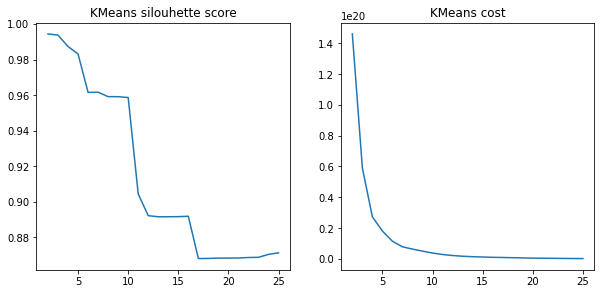

In [ ]:
best_clusterings,best_labels,clusterings_str=evaluate_clusterings(X,clusterings=['KMeans'])
#for i in range(len(best_labels)):
#  plot_clusters(X,best_labels[i],clusterings_str[i])
#feature_grid_clusters(X,best_labels[i],clusterings_str[i])

In [18]:
X_n=normed_functions[columns_to_norm].to_numpy()

  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:3 score:0.9722948098697825


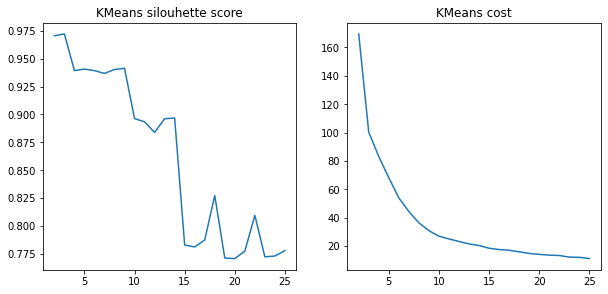

In [ ]:
best_clusterings_n,best_labels_n,clusterings_str_n=evaluate_clusterings(X_n,['KMeans'])
#for i in range(best_labels_n):
#  plot_clusters(X_n,best_labels_N[i],clusterings_str_n[i])
#  feature_grid_clusters(X_n,best_labels_n[0],clusterings_str_n[0])

In [24]:
X_app = app_profiles[columns_to_norm].to_numpy()

  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating KMeans clustering


  0%|          | 0/24 [00:00<?, ?it/s]

best: clusters:2 score:0.9944018034344961


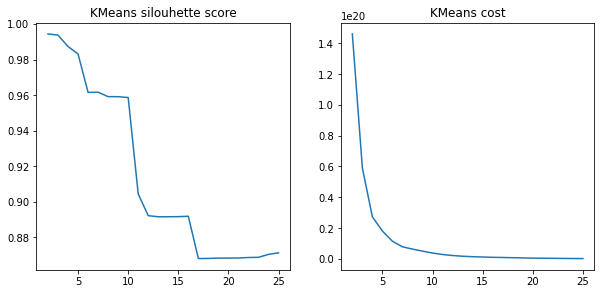

In [20]:
best_clusterings_app,best_labels_app,clusterings_str_app=evaluate_clusterings(X,['KMeans'])

In [32]:
clustering = KMeans(random_state=0,n_clusters=5)
labels=clustering.fit_predict(X)
centers=clustering.cluster_centers_
pd.DataFrame(centers,columns=columns_to_norm)

,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,0.007716,1.489514e+04,4.013424e+04,2.919719e+06,3.703489e+02,7.941467
1,13.868550,1.174467e+07,4.198475e+07,8.092689e+09,5.838700e+06,17339.000000
2,0.747562,8.039394e+05,2.931372e+06,1.986245e+09,2.185621e+05,331.125000
3,0.092895,1.871201e+05,1.590680e+06,1.056074e+09,1.526407e+04,2.963636
4,0.032389,4.153087e+05,1.105755e+06,3.747004e+08,9.757171e+03,877.758824


In [49]:
clustering_n = KMeans(random_state=0,n_clusters=10)
labels_n=clustering_n.fit_predict(X_n)
centers_n=clustering_n.cluster_centers_
pd.DataFrame(centers_n,columns=columns_to_norm)

,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,0.000201,0.001217,0.001763,0.001336,0.001633,0.000461
1,0.466954,0.008293,0.003915,0.003239,0.002890,0.001530
2,0.000484,0.271937,0.118096,0.032533,0.156954,0.409389
3,0.942372,0.023069,0.014012,0.010208,0.008435,0.003763
4,0.013118,0.043323,0.051556,0.184901,0.077967,0.020250
5,0.906243,0.712571,0.594205,0.898758,0.728373,0.886270
6,0.002245,0.027675,0.028520,0.030609,0.028633,0.028054
7,0.015535,0.105567,0.279192,0.625720,0.387331,0.092035
8,0.002441,0.024109,0.022957,0.012850,0.031564,0.220260
9,0.005538,0.555994,0.321881,0.028402,0.040771,0.248772


In [71]:
clustering_app = KMeans(random_state=0,n_clusters=5)
labels_app=clustering_app.fit_predict(X_app)
centers_app=clustering_app.cluster_centers_
pd.DataFrame(centers_app,columns=columns_to_norm)

,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,2.380425,1.685810e+05,6.376072e+05,8.255014e+07,4.375452e+04,325.428571
1,4.566300,1.171686e+07,4.025496e+07,1.197332e+10,1.309847e+06,28230.727273
2,2.601461,2.222301e+07,5.384152e+07,3.983626e+09,4.770941e+05,7848.774194
3,2.008976,6.176294e+06,2.105825e+07,1.451987e+09,1.598289e+05,1872.240000
4,2.736364,2.856721e+05,6.294725e+06,6.315850e+09,3.642305e+05,1360.636364


In [65]:
#get the cluster center where the counters values are the maximum (excluding runtime)
bottleneck=np.unravel_index(np.argmax(centers[1:], axis=None), centers.shape)[0]
functions.loc[labels == bottleneck]

,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
0,disparity,cif,40324,0x7f8630b2a560,0,0.9929,903,1779,2708,107,2
1,disparity,cif,40324,0x7f8630b2cbb1,0,0.0019,5051,11826,127975,2002,64
2,disparity,cif,40324,__wrap_malloc,0,0.0001,236,1543,165633,95,11
3,disparity,cif,40324,__wrap_malloc,1,0.0001,365,1784,156339,48,0
4,disparity,cif,40324,__wrap_malloc,2,0.0002,61,257,121,19,0
...,...,...,...,...,...,...,...,...,...,...,...
58425,tracking,vga,45992,period_handler,0,0.0001,649,1423,2492,86,3
58426,tracking,vga,45992,periodic_benchmark,0,0.9996,853,1997,5040,140,0
58427,tracking,vga,45992,periodic_benchmark,1,0.6912,412,847,623,45,0
58428,tracking,vga,45992,print_timing,0,0.0001,944,1357,1914,128,0


In [64]:
#get the cluster center where the counters values are the maximum (excluding runtime), then print application, function and input size
bottleneck_n=np.unravel_index(np.argmax(centers_n[1:], axis=None), centers_n.shape)[0]
normed_functions.loc[labels_n == bottleneck_n]

,benchmark,input,pid,function,call occurrence,runtime (sec),cache misses,cache references,retired instructions,branch misses,page faults
3506,disparity,sim,39623,0x7fa045aa7bb1,0,0.000851,0.252410,0.131388,0.008531,0.178418,0.311558
3524,disparity,sim,39623,parse_opt,0,0.000100,0.346715,0.175965,0.013888,0.259682,0.437186
3528,disparity,sim,39626,0x7fd6696a2bb1,0,0.000802,0.239160,0.115491,0.009991,0.180434,0.310000
3543,disparity,sim,39626,main,0,0.000050,0.300439,0.155137,0.013081,0.240483,0.415000
3550,disparity,sim,39628,0x7f0107aa6bb1,0,0.000849,0.261525,0.139863,0.013008,0.224182,0.349282
...,...,...,...,...,...,...,...,...,...,...,...
49226,tracking,sim_fast,44560,main,0,0.000050,0.303309,0.100639,0.019220,0.159579,0.491525
49230,tracking,sim_fast,44562,0x7fa912128bb1,0,0.000799,0.204121,0.067672,0.009604,0.102566,0.350575
49307,tracking,sim_fast,44562,main,0,0.000050,0.290632,0.093432,0.018520,0.149390,0.459770
49374,tracking,sim_fast,44566,main,0,0.000050,0.376114,0.110833,0.018701,0.167790,0.713043
